# Performance tricks in OpenVINO for throughput mode

The goal of this notebook is to provide a step-by-step tutorial for improving performance for inferencing in a throughput mode. High throughput is especially desired in applications when the results are not expected to appear as soon as possible but to lower the whole processing time. This notebook assumes computer vision workflow and uses [YOLOv5n](https://github.com/ultralytics/yolov5) model. We will simulate a video processing application that has access to all frames at once (e.g. video editing).

The performance tips applied in this notebook could be summarized in the following figure. Some of the steps below can be applied to any device at any stage, e.g., batch size; some can be used only to specific devices, e.g., inference threads number to CPU. As the number of potential configurations is vast, we recommend looking at the steps below and then apply a trial-and-error approach. You can incorporate many hints simultaneously, like more inference threads + async processing. It should give even better performance, but we recommend testing it anyway.

The quantization and pre-post-processing API are not included here as they change the precision (quantization) or processing graph (prepostprocessor). You can find examples of how to apply them to optimize performance on OpenVINO IR files in [111-detection-quantization](../111-detection-quantization) and [118-optimize-preprocessing](../118-optimize-preprocessing).

![](https://github.com/openvinotoolkit/openvino_notebooks/assets/4547501/ac17148c-bee9-43aa-87fc-ead61ac75f1d)

> **NOTE**: Many of the steps presented below will give you better performance. However, some of them may **not change anything** or even **worsen the performance** if they are strongly dependent on either the hardware or the model. Please run this notebook on your computer with your model to learn which of them makes sense in your case.
>
> All the following tricks were run with OpenVINO 2023.0. Future versions of OpenVINO may include various optimizations that may result in different performance.

A similar notebook focused on the latency mode is available [here](109-latency-tricks.ipynb).

#### Table of contents:
- [Prerequisites](#Prerequisites)
- [Data](#Data)
- [Model](#Model)
- [Hardware](#Hardware)
- [Helper functions](#Helper-functions)
- [Optimizations](#Optimizations)
    - [PyTorch model](#PyTorch-model)
    - [OpenVINO IR model](#OpenVINO-IR-model)
    - [OpenVINO IR model + bigger batch](#OpenVINO-IR-model-+-bigger-batch)
    - [Asynchronous processing](#Asynchronous-processing)
    - [OpenVINO IR model in throughput mode](#OpenVINO-IR-model-in-throughput-mode)
    - [OpenVINO IR model in throughput mode on GPU](#OpenVINO-IR-model-in-throughput-mode-on-GPU)
    - [OpenVINO IR model in throughput mode on AUTO](#OpenVINO-IR-model-in-throughput-mode-on-AUTO)
    - [OpenVINO IR model in cumulative throughput mode on AUTO](#OpenVINO-IR-model-in-cumulative-throughput-mode-on-AUTO)
    - [Other tricks](#Other-tricks)
- [Performance comparison](#Performance-comparison)
- [Conclusions](#Conclusions)


## Prerequisites
[back to top ⬆️](#Table-of-contents:)


In [1]:
%pip install -q "openvino>=2023.1.0" "ultralytics<=8.0.178" seaborn onnx --extra-index-url https://download.pytorch.org/whl/cpu

In [2]:
import time
from pathlib import Path
from typing import Any, List, Tuple

# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)
import notebook_utils as utils

## Data
[back to top ⬆️](#Table-of-contents:)

We will use the same image of the dog sitting on a bicycle copied 1000 times to simulate the video with 1000 frames (about 33s). The image is resized and preprocessed to fulfill the requirements of this particular object detection model.

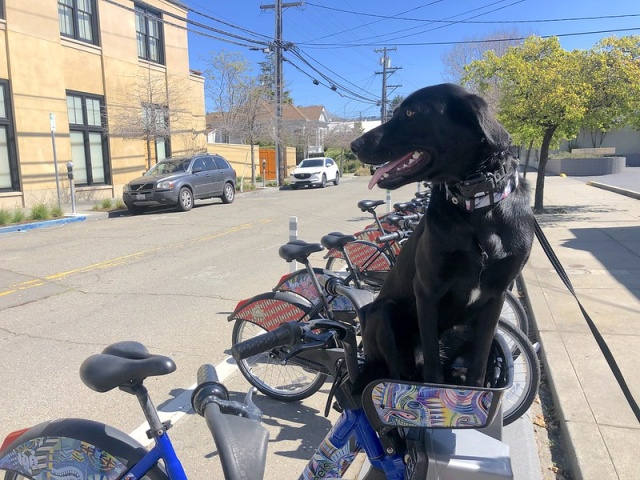

<DisplayHandle display_id=234eecb38312230da22d1a40e616dd00>

In [3]:
import numpy as np
import cv2

FRAMES_NUMBER = 1024

IMAGE_WIDTH = 640
IMAGE_HEIGHT = 480

# load image
image = utils.load_image("https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg")
image = cv2.resize(image, dsize=(IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_AREA)

# preprocess it for YOLOv5
input_image = image / 255.0
input_image = np.transpose(input_image, axes=(2, 0, 1))
input_image = np.expand_dims(input_image, axis=0)

# simulate video with many frames
video_frames = np.tile(input_image, (FRAMES_NUMBER, 1, 1, 1, 1))

# show the image
utils.show_array(image)

## Model
[back to top ⬆️](#Table-of-contents:)

We decided to go with [YOLOv5n](https://github.com/ultralytics/yolov5), one of the state-of-the-art object detection models, easily available through the PyTorch Hub and small enough to see the difference in performance.

In [4]:
import torch
from IPython.utils import io

# directory for all models
base_model_dir = Path("model")

model_name = "yolov5n"
model_path = base_model_dir / model_name

# load YOLOv5n from PyTorch Hub
pytorch_model = torch.hub.load("ultralytics/yolov5", "custom", path=model_path, device="cpu", skip_validation=True)
# don't print full model architecture
with io.capture_output():
    pytorch_model.eval()

Using cache found in /home/abogusze/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-3-7 Python-3.9.17 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


## Hardware
[back to top ⬆️](#Table-of-contents:)

The code below lists the available hardware we will use in the benchmarking process.

> **NOTE**: The hardware you have is probably completely different from ours. It means you can see completely different results.

In [5]:
import openvino as ov

# initialize OpenVINO
core = ov.Core()

# print available devices
for device in core.available_devices:
    device_name = core.get_property(device, "FULL_DEVICE_NAME")
    print(f"{device}: {device_name}")

CPU: 12th Gen Intel(R) Core(TM) i7-12700H
GPU: Intel(R) Graphics [0x46a6] (iGPU)


## Helper functions
[back to top ⬆️](#Table-of-contents:)

We're defining a benchmark model function to use for all optimizations below. It runs inference for 1000 frames and prints average frames per second (FPS).

In [6]:
from openvino.runtime import AsyncInferQueue


def benchmark_model(model: Any, frames: np.ndarray, async_queue: AsyncInferQueue = None, benchmark_name: str = "OpenVINO model", device_name: str = "CPU") -> float:
    """
    Helper function for benchmarking the model. It measures the time and prints results.
    """
    # measure the first inference separately - it may be slower as it contains also initialization
    start = time.perf_counter()
    model(frames[0])
    if async_queue:
        async_queue.wait_all()
    end = time.perf_counter()
    first_infer_time = end - start
    print(f"{benchmark_name} on {device_name}. First inference time: {first_infer_time :.4f} seconds")

    # benchmarking
    start = time.perf_counter()
    for batch in frames:
        model(batch)
    # wait for all threads if async processing
    if async_queue:
        async_queue.wait_all()
    end = time.perf_counter()

    # elapsed time
    infer_time = end - start

    # print second per image and FPS
    mean_infer_time = infer_time / FRAMES_NUMBER
    mean_fps = FRAMES_NUMBER / infer_time
    print(f"{benchmark_name} on {device_name}: {mean_infer_time :.4f} seconds per image ({mean_fps :.2f} FPS)")

    return mean_fps

The following functions aim to post-process results and draw boxes on the image.

In [7]:
# https://gist.github.com/AruniRC/7b3dadd004da04c80198557db5da4bda
classes = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant",
    "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra",
    "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite",
    "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork",
    "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake", "chair", "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard",
    "cell phone", "microwave", "oven", "oaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear",
    "hair drier", "toothbrush"
]

# Colors for the classes above (Rainbow Color Map).
colors = cv2.applyColorMap(
    src=np.arange(0, 255, 255 / len(classes), dtype=np.float32).astype(np.uint8),
    colormap=cv2.COLORMAP_RAINBOW,
).squeeze()


def postprocess(detections: np.ndarray) -> List[Tuple]:
    """
    Postprocess the raw results from the model.
    """
    # candidates - probability > 0.25
    detections = detections[detections[..., 4] > 0.25]

    boxes = []
    labels = []
    scores = []
    for obj in detections:
        xmin, ymin, ww, hh = obj[:4]
        score = obj[4]
        label = np.argmax(obj[5:])
        # Create a box with pixels coordinates from the box with normalized coordinates [0,1].
        boxes.append(
            tuple(map(int, (xmin - ww // 2, ymin - hh // 2, ww, hh)))
        )
        labels.append(int(label))
        scores.append(float(score))

    # Apply non-maximum suppression to get rid of many overlapping entities.
    # See https://paperswithcode.com/method/non-maximum-suppression
    # This algorithm returns indices of objects to keep.
    indices = cv2.dnn.NMSBoxes(
        bboxes=boxes, scores=scores, score_threshold=0.25, nms_threshold=0.5
    )

    # If there are no boxes.
    if len(indices) == 0:
        return []

    # Filter detected objects.
    return [(labels[idx], scores[idx], boxes[idx]) for idx in indices.flatten()]


def draw_boxes(img: np.ndarray, boxes):
    """
    Draw detected boxes on the image.
    """
    for label, score, box in boxes:
        # Choose color for the label.
        color = tuple(map(int, colors[label]))
        # Draw a box.
        x2 = box[0] + box[2]
        y2 = box[1] + box[3]
        cv2.rectangle(img=img, pt1=box[:2], pt2=(x2, y2), color=color, thickness=2)

        # Draw a label name inside the box.
        cv2.putText(
            img=img,
            text=f"{classes[label]} {score:.2f}",
            org=(box[0] + 10, box[1] + 20),
            fontFace=cv2.FONT_HERSHEY_COMPLEX,
            fontScale=img.shape[1] / 1200,
            color=color,
            thickness=1,
            lineType=cv2.LINE_AA,
        )


def show_result(results: np.ndarray):
    """
    Postprocess the raw results, draw boxes and show the image.
    """
    output_img = image.copy()

    detections = postprocess(results)
    draw_boxes(output_img, detections)

    utils.show_array(output_img)

## Optimizations
[back to top ⬆️](#Table-of-contents:)

Below, we present the performance tricks for faster inference in the throughput mode. We release resources after every benchmarking to be sure the same amount of resource is available for every experiment.

### PyTorch model
[back to top ⬆️](#Table-of-contents:)

First, we're benchmarking the original PyTorch model without any optimizations applied. We will treat it as our baseline.

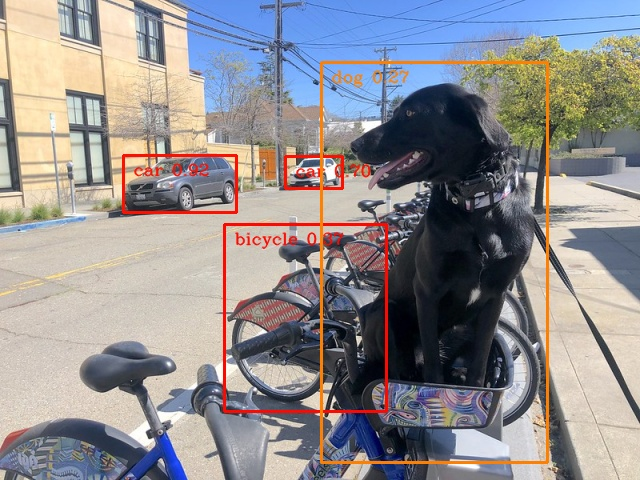

PyTorch model on CPU. First inference time: 0.0214 seconds
PyTorch model on CPU: 0.0228 seconds per image (43.92 FPS)


In [8]:
import torch

with torch.no_grad():
    result = pytorch_model(torch.as_tensor(video_frames[0])).detach().numpy()[0]
    show_result(result)
    pytorch_fps = benchmark_model(pytorch_model, frames=torch.as_tensor(video_frames).float(), benchmark_name="PyTorch model")

### OpenVINO IR model
[back to top ⬆️](#Table-of-contents:)

The first optimization is exporting the PyTorch model to OpenVINO Intermediate Representation (IR) FP16 and running it. Reducing the precision is one of the well-known methods for faster inference provided the hardware that supports lower precision, such as FP16 or even INT8. If the hardware doesn't support lower precision, the model will be inferred in FP32 automatically. We could also use quantization (INT8), but we should experience a little accuracy drop. That's why we skip that step in this notebook.

In [9]:
onnx_path = base_model_dir / Path(f"{model_name}_{IMAGE_WIDTH}_{IMAGE_HEIGHT}").with_suffix(".onnx")

# export PyTorch model to ONNX if it doesn't already exist
if not onnx_path.exists():
    dummy_input = torch.randn(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)
    torch.onnx.export(pytorch_model, dummy_input, onnx_path)

# convert ONNX model to IR, use FP16
ov_model = ov.convert_model(onnx_path)

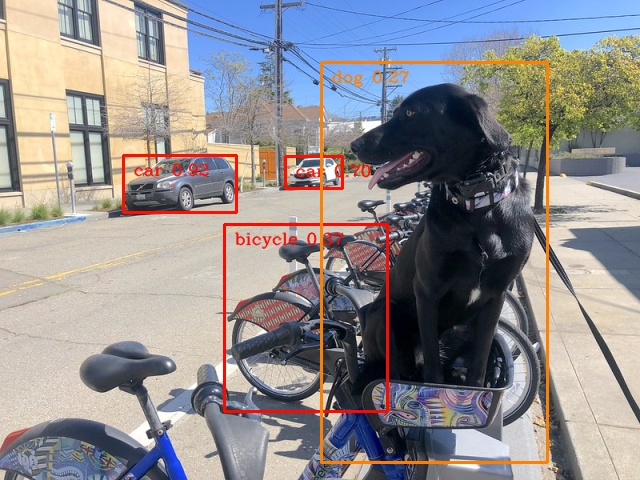

OpenVINO model on CPU. First inference time: 0.0156 seconds
OpenVINO model on CPU: 0.0090 seconds per image (111.65 FPS)


In [10]:
ov_cpu_model = core.compile_model(ov_model, device_name="CPU")

result = ov_cpu_model(video_frames[0])[ov_cpu_model.output(0)][0]
show_result(result)
ov_cpu_fps = benchmark_model(model=ov_cpu_model, frames=video_frames, benchmark_name="OpenVINO model")

del ov_cpu_model  # release resources

### OpenVINO IR model + bigger batch
[back to top ⬆️](#Table-of-contents:)

Batch processing often gives higher throughput as more inputs are processed at once. To use bigger batches (than 1), we must convert the model again, specifying a new input shape, and reshape input frames. In our case, a batch size equal to 4 is the best choice, but optimal batch size is very device-specific and depends on many factors, e.g., inference precision. We recommend trying various sizes for other hardware and model.

In [12]:
batch_size = 4

onnx_batch_path = base_model_dir / Path(f"{model_name}_{IMAGE_WIDTH}_{IMAGE_HEIGHT}_batch_{batch_size}").with_suffix(".onnx")

if not onnx_batch_path.exists():
    dummy_input = torch.randn(batch_size, 3, IMAGE_HEIGHT, IMAGE_WIDTH)
    torch.onnx.export(pytorch_model, dummy_input, onnx_batch_path)

# export the model with the bigger batch size
ov_batch_model = ov.convert_model(onnx_batch_path)

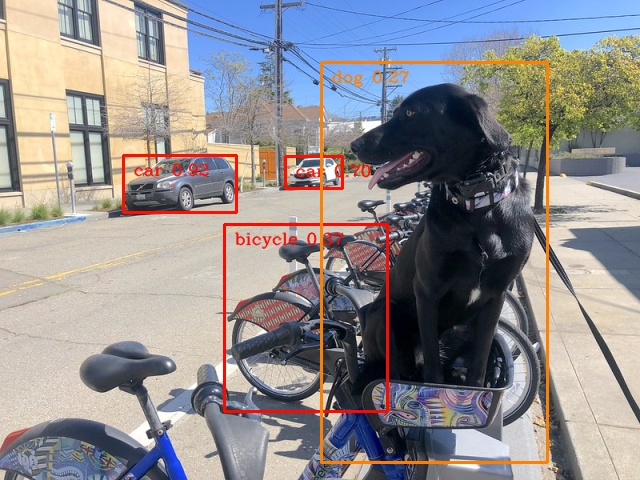

OpenVINO model + bigger batch on CPU. First inference time: 0.0378 seconds
OpenVINO model + bigger batch on CPU: 0.0088 seconds per image (113.99 FPS)


In [13]:
ov_cpu_batch_model = core.compile_model(ov_batch_model, device_name="CPU")

batched_video_frames = video_frames.reshape([-1, batch_size, 3, IMAGE_HEIGHT, IMAGE_WIDTH])

result = ov_cpu_batch_model(batched_video_frames[0])[ov_cpu_batch_model.output(0)][0]
show_result(result)
ov_cpu_batch_fps = benchmark_model(model=ov_cpu_batch_model, frames=batched_video_frames, benchmark_name="OpenVINO model + bigger batch")

del ov_cpu_batch_model  # release resources

### Asynchronous processing
[back to top ⬆️](#Table-of-contents:)

Asynchronous mode means that OpenVINO immediately returns from an inference call and doesn't wait for the result. It requires more concurrent code to be written, but should offer better processing time utilization e.g. we can run some pre- or post-processing code while waiting for the result. Although we could use async processing directly (start_async() function), it's recommended to use AsyncInferQueue, which is an easier approach to achieve the same outcome. This class automatically spawns the pool of InferRequest objects (also called “jobs”) and provides synchronization mechanisms to control the flow of the pipeline.

> **NOTE**: Asynchronous processing cannot guarantee outputs to be in the same order as inputs, so be careful in case of applications when the order of frames matters, e.g., videos.

In [15]:
def benchmark_async_mode(ov_model, benchmark_name, device_name):
    def callback(infer_request, info):
        result = infer_request.get_output_tensor(0).data[0]
        show_result(result)
        pass

    infer_queue = ov.AsyncInferQueue(ov_model)
    infer_queue.set_callback(callback)  # set callback to post-process (show) results

    infer_queue.start_async(video_frames[0])
    infer_queue.wait_all()

    # don't show output for the remaining frames
    infer_queue.set_callback(lambda x, y: {})
    fps = benchmark_model(model=infer_queue.start_async, frames=video_frames, async_queue=infer_queue, benchmark_name=benchmark_name, device_name=device_name)

    del infer_queue  # release resources
    return fps

### OpenVINO IR model in throughput mode
[back to top ⬆️](#Table-of-contents:)

OpenVINO allows specifying a performance hint changing the internal configuration of the device. There are three different hints: `LATENCY`, `THROUGHPUT`, and `CUMULATIVE_THROUGHPUT`. As this notebook is focused on the throughput mode, we will use the latter two. The hints can be used with other devices as well. Throughput mode implicitly triggers using the [Automatic Batching](https://docs.openvino.ai/2023.3/openvino_docs_OV_UG_Automatic_Batching.html) feature, which sets the batch size to the optimal level.

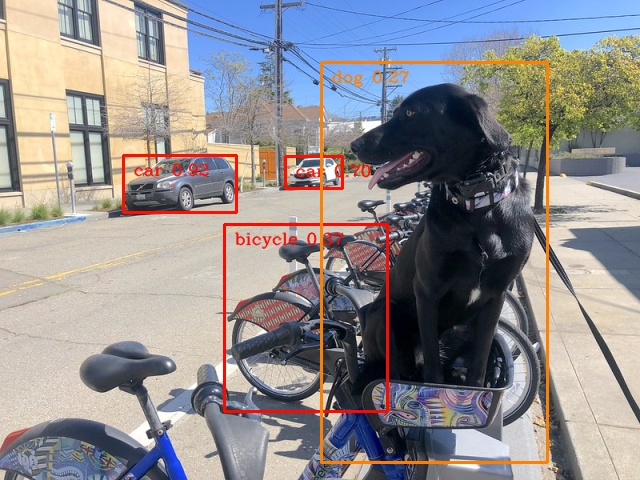

OpenVINO model on CPU (THROUGHPUT). First inference time: 0.0155 seconds
OpenVINO model on CPU (THROUGHPUT): 0.0058 seconds per image (173.67 FPS)


In [16]:
ov_cpu_through_model = core.compile_model(ov_model, device_name="CPU", config={"PERFORMANCE_HINT": "THROUGHPUT"})

ov_cpu_through_fps = benchmark_async_mode(ov_cpu_through_model, benchmark_name="OpenVINO model", device_name="CPU (THROUGHPUT)")

del ov_cpu_through_model  # release resources

### OpenVINO IR model in throughput mode on GPU
[back to top ⬆️](#Table-of-contents:)

Usually, a GPU device provides more frames per second than a CPU, so let's run the above model on the GPU. Please note you need to have an Intel GPU and [install drivers](https://github.com/openvinotoolkit/openvino_notebooks/wiki/Ubuntu#1-install-python-git-and-gpu-drivers-optional) to be able to run this step. In addition, offloading to the GPU helps reduce CPU load and memory consumption, allowing it to be left for routine processes. If you cannot observe a higher throughput on GPU, it may be because the model is too light to benefit from massive parallel execution.

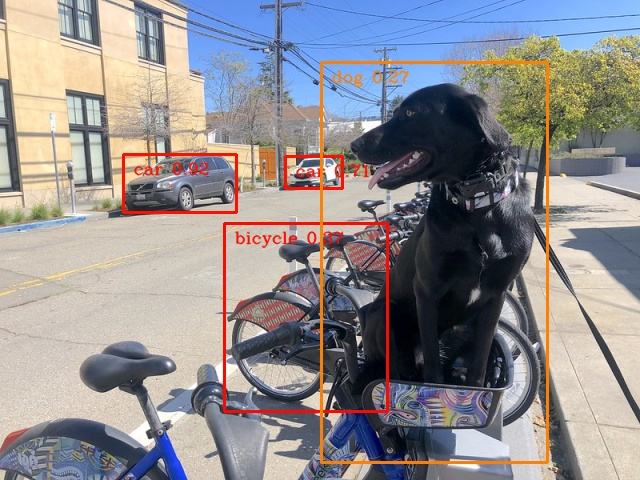

OpenVINO model on GPU (THROUGHPUT). First inference time: 0.0088 seconds
OpenVINO model on GPU (THROUGHPUT): 0.0050 seconds per image (200.00 FPS)


In [17]:
ov_gpu_fps = 0.0
if "GPU" in core.available_devices:
    # compile for GPU
    ov_gpu_model = core.compile_model(ov_model, device_name="GPU", config={"PERFORMANCE_HINT": "THROUGHPUT"})

    ov_gpu_fps = benchmark_async_mode(ov_gpu_model, benchmark_name="OpenVINO model", device_name="GPU (THROUGHPUT)")

    del ov_gpu_model  # release resources

### OpenVINO IR model in throughput mode on AUTO
[back to top ⬆️](#Table-of-contents:)

OpenVINO offers a virtual device called [AUTO](https://docs.openvino.ai/2023.3/openvino_docs_OV_UG_supported_plugins_AUTO.html), which can select the best device for us based on the aforementioned performance hint.

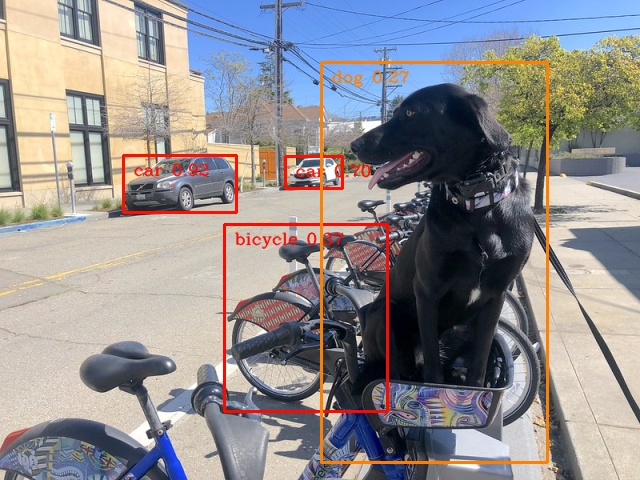

OpenVINO model on AUTO (THROUGHPUT). First inference time: 0.0172 seconds
OpenVINO model on AUTO (THROUGHPUT): 0.0064 seconds per image (157.01 FPS)


In [18]:
ov_auto_model = core.compile_model(ov_model, device_name="AUTO", config={"PERFORMANCE_HINT": "THROUGHPUT"})

ov_auto_fps = benchmark_async_mode(ov_auto_model, benchmark_name="OpenVINO model", device_name="AUTO (THROUGHPUT)")

del ov_auto_model  # release resources

### OpenVINO IR model in cumulative throughput mode on AUTO
[back to top ⬆️](#Table-of-contents:)

The AUTO device in throughput mode will select the best, but one physical device to bring the highest throughput. However, if we have more Intel devices like CPU, iGPUs, and dGPUs in one machine, we may benefit from them all. To do so, we must use cumulative throughput to activate all devices.

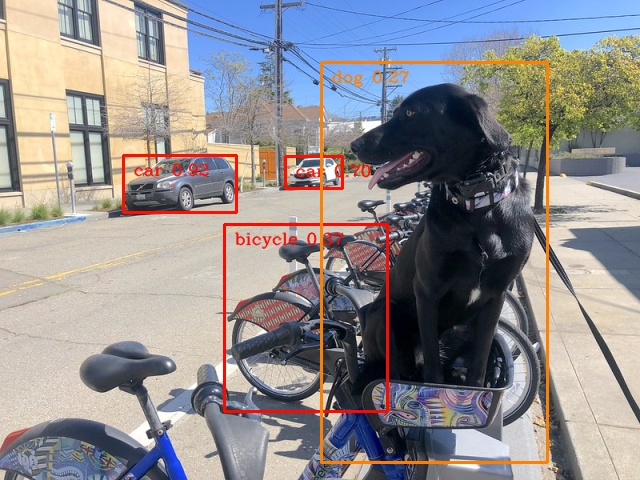

OpenVINO model on AUTO (CUMULATIVE THROUGHPUT). First inference time: 0.0177 seconds
OpenVINO model on AUTO (CUMULATIVE THROUGHPUT): 0.0035 seconds per image (285.51 FPS)


In [19]:
ov_auto_cumulative_model = core.compile_model(ov_model, device_name="AUTO", config={"PERFORMANCE_HINT": "CUMULATIVE_THROUGHPUT"})

ov_auto_cumulative_fps = benchmark_async_mode(ov_auto_cumulative_model, benchmark_name="OpenVINO model", device_name="AUTO (CUMULATIVE THROUGHPUT)")

### Other tricks
[back to top ⬆️](#Table-of-contents:)

There are other tricks for performance improvement, such as advanced options, quantization and pre-post-processing or dedicated to latency mode. To get even more from your model, please visit [advanced throughput options](https://docs.openvino.ai/2023.3/openvino_docs_deployment_optimization_guide_tput_advanced.html), [109-latency-tricks](109-latency-tricks.ipynb), [111-detection-quantization](../111-detection-quantization), and [118-optimize-preprocessing](../118-optimize-preprocessing).

## Performance comparison
[back to top ⬆️](#Table-of-contents:)

The following graphical comparison is valid for the selected model and hardware simultaneously. If you cannot see any improvement between some steps, just skip them.

In [20]:
%matplotlib inline

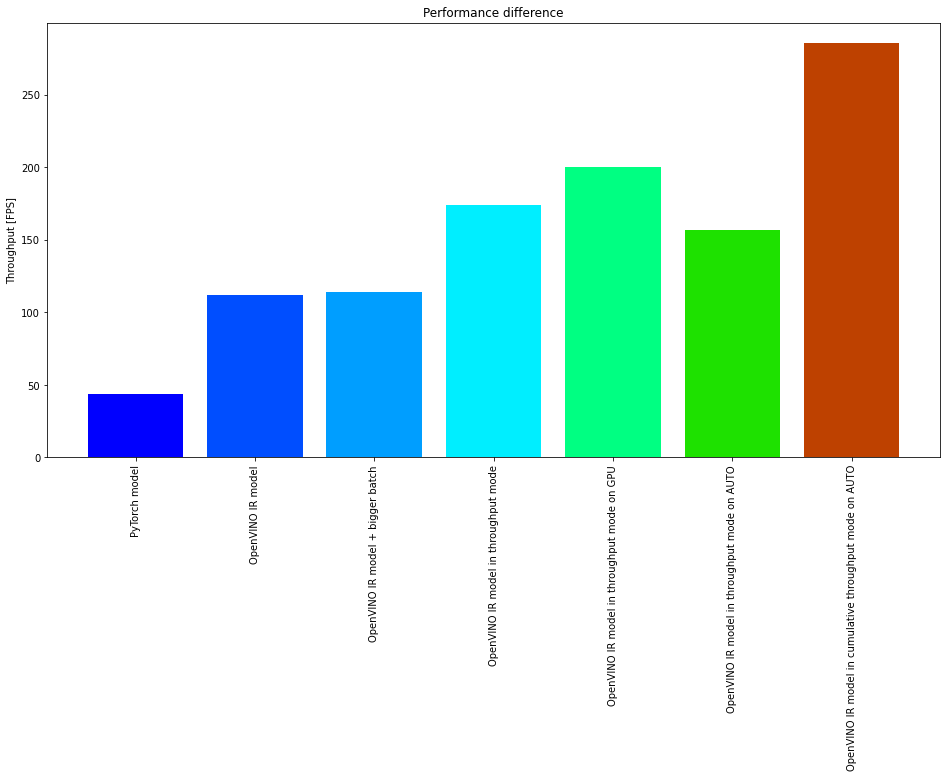

In [21]:
from matplotlib import pyplot as plt

labels = ["PyTorch model", "OpenVINO IR model", "OpenVINO IR model + bigger batch", "OpenVINO IR model in throughput mode", "OpenVINO IR model in throughput mode on GPU",
          "OpenVINO IR model in throughput mode on AUTO", "OpenVINO IR model in cumulative throughput mode on AUTO"]

fps = [pytorch_fps, ov_cpu_fps, ov_cpu_batch_fps, ov_cpu_through_fps, ov_gpu_fps, ov_auto_fps, ov_auto_cumulative_fps]

bar_colors = colors[::10] / 255.0

fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(labels, fps, color=bar_colors)

ax.set_ylabel("Throughput [FPS]")
ax.set_title("Performance difference")

plt.xticks(rotation='vertical')
plt.show()

## Conclusions
[back to top ⬆️](#Table-of-contents:)

We already showed the steps needed to improve the throughput of an object detection model. Even if you experience much better performance after running this notebook, please note this may not be valid for every hardware or every model. For the most accurate results, please use `benchmark_app` [command-line tool](https://docs.openvino.ai/2023.3/openvino_sample_benchmark_tool). Note that `benchmark_app` cannot measure the impact of some tricks above.